Classifying text with TensorFlow Estimators
===

This notebook demonstrates how to tackle a text classification problem using custom TensorFlow estimators, embeddings and the [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) module. Along the way we'll learn about word2vec and transfer learning as a technique to bootstrap model performance when labeled data is a scarce resource.

## Setup

Let's begin importing the libraries we'll need. This notebook runs in Python 3 and TensorFlow v1.4 or more, but it can run in earlier versions of TensorFlow by replacing some of the import statements to the corresponding paths inside the `contrib` module.

### The IMDB Dataset

The dataset we wil be using is the IMDB [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/), which consists of $25,000$ highly polar movie reviews for training, and $25,000$ for testing. We will use this dataset to train a binary classifiation model, able to predict whether a review is positive or negative.

In [1]:
import os
import string
import tempfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.keras.datasets import imdb
from tensorflow.python.keras.preprocessing import sequence
from tensorboard import summary as summary_lib

tf.logging.set_verbosity(tf.logging.INFO)
print(tf.__version__)

1.10.0


### Loading the data

Keras provides a convenient handler for importing the dataset which is also available as a serialized numpy array `.npz` file to download [here]( https://s3.amazonaws.com/text-datasets/imdb.npz). Each review consists of a series of word indexes that go from $4$ (the most frequent word in the dataset, **the**) to $4999$, which corresponds to **orange**. Index $1$ represents the beginning of the sentence and the index $2$ is assigned to all unknown (also known as *out-of-vocabulary* or *OOV*) tokens. These indexes have been obtained by pre-processing the text data in a pipeline that cleans, normalizes and tokenizes each sentence first and then builds a dictionary indexing each of the tokens by frequency. We are not convering these techniques in this post, but you can take a look at [this chapter](http://www.nltk.org/book/ch03.html) of the NLTK book to learn more.

It's standard to limit the size of the vocabulary to prevent the dataset from becoming too sparse and high dimensional, causing potential overfitting. After we've loaded the data in memory we pad each of the sentences with $0$ to a fixed size (here: $200$) so that we have two $2$-dimensional $25000\times200$ arrays for training and testing respectively.



In [2]:
vocab_size = 5000
sentence_size = 200
embedding_size = 50
model_dir = tempfile.mkdtemp()

# we assign the first indices in the vocabulary to special tokens that we use
# for padding, as start token, and for indicating unknown words
pad_id = 0
start_id = 1
oov_id = 2
index_offset = 2

print("Loading data...")
(x_train_variable, y_train), (x_test_variable, y_test) = imdb.load_data(
    num_words=vocab_size, start_char=start_id, oov_char=oov_id,
    index_from=index_offset)
print(len(y_train), "train sequences")
print(len(y_test), "test sequences")

print("Pad sequences (samples x time)")
x_train = sequence.pad_sequences(x_train_variable, 
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)
x_test = sequence.pad_sequences(x_test_variable, 
                                maxlen=sentence_size,
                                truncating='post',
                                padding='post', 
                                value=pad_id)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

Loading data...
17465344/17464789 [==============================] - 8s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 200)
x_test shape: (25000, 200)


We can use the word index map to inspect how the first review looks like.

In [3]:
word_index = imdb.get_word_index()
word_inverted_index = {v + index_offset: k for k, v in word_index.items()}

# The first indexes in the map are reserved to represent things other than tokens
word_inverted_index[pad_id] = '<PAD>'
word_inverted_index[start_id] = '<START>'
word_inverted_index[oov_id] = '<OOV>'

print(x_train_variable[0])
print(x_train[0])

for i in range(0, 10):
      print(i, word_inverted_index[i])
  
def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

print(index_to_text(x_train_variable[0]))

1646592/1641221 [==============================] - 1s 1us/step
[1, 13, 21, 15, 42, 529, 972, 1621, 1384, 64, 457, 4467, 65, 3940, 3, 172, 35, 255, 4, 24, 99, 42, 837, 111, 49, 669, 2, 8, 34, 479, 283, 4, 149, 3, 171, 111, 166, 2, 335, 384, 38, 3, 171, 4535, 1110, 16, 545, 37, 12, 446, 3, 191, 49, 15, 5, 146, 2024, 18, 13, 21, 3, 1919, 4612, 468, 3, 21, 70, 86, 11, 15, 42, 529, 37, 75, 14, 12, 1246, 3, 21, 16, 514, 16, 11, 15, 625, 17, 2, 4, 61, 385, 11, 7, 315, 7, 105, 4, 3, 2222, 2, 15, 479, 65, 3784, 32, 3, 129, 11, 15, 37, 618, 4, 24, 123, 50, 35, 134, 47, 24, 1414, 32, 5, 21, 11, 214, 27, 76, 51, 4, 13, 406, 15, 81, 2, 7, 3, 106, 116, 2, 14, 255, 3, 2, 6, 3765, 4, 722, 35, 70, 42, 529, 475, 25, 399, 316, 45, 6, 3, 2, 1028, 12, 103, 87, 3, 380, 14, 296, 97, 31, 2070, 55, 25, 140, 5, 193, 2, 17, 3, 225, 21, 20, 133, 475, 25, 479, 4, 143, 29, 2, 17, 50, 35, 27, 223, 91, 24, 103, 3, 225, 64, 15, 37, 1333, 87, 11, 15, 282, 4, 15, 4471, 112, 102, 31, 14, 15, 2, 18, 177, 31]
[   1   13   

## Building Estimators

In the next section we will build several models to make predictions for the labels in the dataset. We will first use canned estimators and then create custom ones for the task. We recommend that you check out [this blog post](https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html) that explains how to use the `tf.feature_column` module to standardize and abstract how raw input data is processed and [the following one](https://developers.googleblog.com/2017/12/creating-custom-estimators-in-tensorflow.html) that covers in depth how to work with Estimators.

### From arrays to tensors

There's one more thing we need to do get our data ready for TensorFlow. We need to convert the data from numpy arrays into Tensors. Fortunately for us the `Dataset` module has us covered. 

It provides a handy function, `from_tensor_slices` that creates the dataset to which we can then apply multiple transformations to shuffle, batch and repeat samples and plug into our training pipeline. Moreover, with just a few changes we could be loading the data from files on disk and the framework does all the memory management.

We define two input functions: one for processing the training data and one for processing the test data. We shuffle the training data and do not predefine the number of epochs we want to train, while we only need one epoch of the test data for evaluation. We also add an additional `"len"` key to both that captures the length of the original, unpadded sequence, which we will use later.

In [4]:
x_len_train = np.array([min(len(x), sentence_size) for x in x_train_variable])
x_len_test = np.array([min(len(x), sentence_size) for x in x_test_variable])

def parser(x, length, y):
    features = {"x": x, "len": length}
    return features, y

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_train, x_len_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(x_train_variable))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    dataset = dataset.repeat()
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_test, x_len_test, y_test))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

### Baselines

It's always a good practice to start any machine learning project trying out a couple of reliable baselines. Simple is always better and it is key to understand exactly how much we are gaining in terms of performance by adding extra complexity. It may very well be the case that a simple solution is good enough for our requirements.

With that in mind, let us start by trying out one of the simplest models out there for text classification. That is, a sparse linear model that gives a weight to each token and adds up all of the results, regardless of the order. The fact that we don't care about the order of the words in the sentence is the reason why this method is generally known as a Bag-of-Words (BOW) approach. Let's see how that works out.

We start out by defining the feature column that is used as input to our classifier. As we've seen [in this blog post](https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html), `categorical_column_with_identity` is the right choice for this pre-processed text input. If we were feeding raw text tokens, other `feature_columns` could do a lot of the pre-processing for us. We can now use the pre-made `LinearClassifier`.

In [5]:
column = tf.feature_column.categorical_column_with_identity('x', vocab_size)
classifier = tf.estimator.LinearClassifier(feature_columns=[column], model_dir=os.path.join(model_dir, 'bow_sparse'))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/k4/43q590p14fvg8tp64ns2kxlr0000gn/T/tmpk96t_2h3/bow_sparse', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb24786f98>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Finally, we create a simple function that trains the classifier and additionally creates a precision-recall curve. Note that we do not aim to maximize performance in this blog post, so we only train our models for $25,000$ steps.

In [6]:
all_classifiers = {}
def train_and_evaluate(classifier):
    # Save a reference to the classifier to run predictions later
    all_classifiers[classifier.model_dir] = classifier
    classifier.train(input_fn=train_input_fn, steps=25000)
    eval_results = classifier.evaluate(input_fn=eval_input_fn)
    predictions = np.array([p['logistic'][0] for p in classifier.predict(input_fn=eval_input_fn)])
        
    # Reset the graph to be able to reuse name scopes
    tf.reset_default_graph() 
    # Add a PR summary in addition to the summaries that the classifier writes
    pr = summary_lib.pr_curve('precision_recall', predictions=predictions, labels=y_test.astype(bool), num_thresholds=21)
    with tf.Session() as sess:
        writer = tf.summary.FileWriter(os.path.join(classifier.model_dir, 'eval'), sess.graph)
        writer.add_summary(sess.run(pr), global_step=0)
        writer.close()
#     # Un-comment code to download experiment data from Colaboratory
#     from google.colab import files
#     model_name = os.path.basename(os.path.normpath(classifier.model_dir))
#     ! zip -r {model_name + '.zip'} {classifier.model_dir}
#     files.download(model_name + '.zip')

In [7]:
train_and_evaluate(classifier)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/k4/43q590p14fvg8tp64ns2kxlr0000gn/T/tmpk96t_2h3/bow_sparse/model.ckpt.
INFO:tensorflow:loss = 69.31472, step = 1
INFO:tensorflow:global_step/sec: 89.0506
INFO:tensorflow:loss = 42.11712, step = 101 (1.124 sec)
INFO:tensorflow:global_step/sec: 264.683
INFO:tensorflow:loss = 37.884876, step = 201 (0.378 sec)
INFO:tensorflow:global_step/sec: 245.6
INFO:tensorflow:loss = 38.361668, step = 301 (0.407 sec)
INFO:tensorflow:global_step/sec: 268.304
INFO:tensorflow:loss = 27.477201, step = 401 (0.373 sec)
INFO:tensorflow:global_step/sec: 241.822
INFO:tensorflow:loss = 28.557194, step = 501 (0.414 sec)
INFO:tensorflow:global_step/sec: 282.933
INFO:tensorflow:loss = 25.543917, step = 601 (0.353 sec)
INFO:t

INFO:tensorflow:global_step/sec: 220.647
INFO:tensorflow:loss = 11.062544, step = 8001 (0.453 sec)
INFO:tensorflow:global_step/sec: 287.877
INFO:tensorflow:loss = 11.635772, step = 8101 (0.347 sec)
INFO:tensorflow:global_step/sec: 264.904
INFO:tensorflow:loss = 16.452856, step = 8201 (0.377 sec)
INFO:tensorflow:global_step/sec: 249.879
INFO:tensorflow:loss = 13.68065, step = 8301 (0.400 sec)
INFO:tensorflow:global_step/sec: 274.223
INFO:tensorflow:loss = 13.814989, step = 8401 (0.365 sec)
INFO:tensorflow:global_step/sec: 247.158
INFO:tensorflow:loss = 9.83744, step = 8501 (0.405 sec)
INFO:tensorflow:global_step/sec: 287.882
INFO:tensorflow:loss = 17.16531, step = 8601 (0.348 sec)
INFO:tensorflow:global_step/sec: 269.324
INFO:tensorflow:loss = 15.249129, step = 8701 (0.371 sec)
INFO:tensorflow:global_step/sec: 250.8
INFO:tensorflow:loss = 18.733057, step = 8801 (0.398 sec)
INFO:tensorflow:global_step/sec: 284.897
INFO:tensorflow:loss = 14.663479, step = 8901 (0.351 sec)
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 253.166
INFO:tensorflow:loss = 12.421133, step = 16301 (0.395 sec)
INFO:tensorflow:global_step/sec: 271.502
INFO:tensorflow:loss = 12.370745, step = 16401 (0.369 sec)
INFO:tensorflow:global_step/sec: 249.712
INFO:tensorflow:loss = 12.903804, step = 16501 (0.400 sec)
INFO:tensorflow:global_step/sec: 279.803
INFO:tensorflow:loss = 14.05884, step = 16601 (0.357 sec)
INFO:tensorflow:global_step/sec: 280.81
INFO:tensorflow:loss = 12.984841, step = 16701 (0.357 sec)
INFO:tensorflow:global_step/sec: 258.241
INFO:tensorflow:loss = 9.547062, step = 16801 (0.387 sec)
INFO:tensorflow:global_step/sec: 275.787
INFO:tensorflow:loss = 12.4458885, step = 16901 (0.363 sec)
INFO:tensorflow:global_step/sec: 250.393
INFO:tensorflow:loss = 8.014865, step = 17001 (0.399 sec)
INFO:tensorflow:global_step/sec: 293.344
INFO:tensorflow:loss = 12.953149, step = 17101 (0.341 sec)
INFO:tensorflow:global_step/sec: 271.748
INFO:tensorflow:loss = 14.119703, step = 17201 (0.368 sec)
INF

INFO:tensorflow:loss = 16.653875, step = 24501 (0.400 sec)
INFO:tensorflow:global_step/sec: 277.1
INFO:tensorflow:loss = 8.871648, step = 24601 (0.361 sec)
INFO:tensorflow:global_step/sec: 277.207
INFO:tensorflow:loss = 11.620888, step = 24701 (0.361 sec)
INFO:tensorflow:global_step/sec: 255.834
INFO:tensorflow:loss = 14.012723, step = 24801 (0.391 sec)
INFO:tensorflow:global_step/sec: 273.583
INFO:tensorflow:loss = 12.210503, step = 24901 (0.365 sec)
INFO:tensorflow:Saving checkpoints for 25000 into /var/folders/k4/43q590p14fvg8tp64ns2kxlr0000gn/T/tmpk96t_2h3/bow_sparse/model.ckpt.
INFO:tensorflow:Loss for final step: 15.082939.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-14-15:01:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/k4/43q590p14fvg8tp64ns2kxlr0000gn/T/tmpk96t_2h3/bow_sparse/model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done ru

One of the benefits of choosing a simple model is that it's much more inspectable. The more complex the model is, the more it tends to work like a black box. In this example we can load the weights from our model's last checkpoint and take a look at what tokens correspond to the  biggest weights in absolute value. The results looks like what we would expect

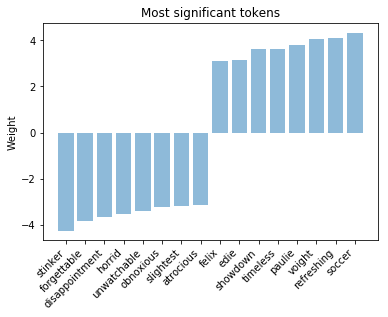

In [8]:
weights = classifier.get_variable_value('linear/linear_model/x/weights').flatten()
sorted_indexes = np.argsort(weights)
extremes = np.concatenate((sorted_indexes[-8:], sorted_indexes[:8]))
extreme_weights = sorted([(weights[i], word_inverted_index[i]) for i in extremes])

y_pos = np.arange(len(extreme_weights))
plt.bar(y_pos, [pair[0] for pair in extreme_weights], align='center', alpha=0.5)
plt.xticks(y_pos, [pair[1] for pair in extreme_weights], rotation=45, ha='right')
plt.ylabel('Weight')
plt.title('Most significant tokens') 
plt.show()

As we can see, tokens with the most positive weight such as 'refreshing' are clearly associated with positive sentiment, while tokens that have a large negative weight unarguably evoke negative emotions. A simple but powerful modification that one can do to improve this model is weighting the tokens by their [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) scores.

### Embeddings

The next step of complexity we can add are word embeddings. Embeddings are a dense low-dimensional representation of sparse high-dimensional data. This allows our model to learn a more meaningful representation of each token, rather than just an index. While an individual dimension is not meaningful, the low-dimensional space---when learned from a large enough corpus---has been shown to capture relations such as tense, plural, gender, thematic relatedness, and many more. We can add word embeddings by converting our existing feature column into an `embedding_column`. The representation seen by the model is the mean of the embeddings for each token (see the `combiner` argument in the [docs](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column)). We can plug in the embedded features into a pre-canned `DNNClassifier`. 

A note for the keen observer: an `embedding_column` is just an efficient way of applying a fully connected layer to the sparse binary feature vector of tokens, which is multiplied by a constant depending on the chosen combiner. A direct consequence of this is that it wouldn't make sense to use an `embedding_column` directly in a `LinearClassifier` because two consecutive linear layers without non-linearities in between add no prediction power to the model, unless of course the embeddings are pre-trained.

In [9]:
word_embedding_column = tf.feature_column.embedding_column(column, dimension=embedding_size)
classifier = tf.estimator.DNNClassifier(
    hidden_units=[100],
    feature_columns=[word_embedding_column], 
    model_dir=os.path.join(model_dir, 'bow_embeddings'))
train_and_evaluate(classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/k4/43q590p14fvg8tp64ns2kxlr0000gn/T/tmpk96t_2h3/bow_embeddings', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb259cf080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving chec

INFO:tensorflow:global_step/sec: 159.841
INFO:tensorflow:loss = 7.4469395, step = 7301 (0.625 sec)
INFO:tensorflow:global_step/sec: 165.035
INFO:tensorflow:loss = 6.617629, step = 7401 (0.607 sec)
INFO:tensorflow:global_step/sec: 160.008
INFO:tensorflow:loss = 2.9226317, step = 7501 (0.624 sec)
INFO:tensorflow:global_step/sec: 183.228
INFO:tensorflow:loss = 3.6344173, step = 7601 (0.547 sec)
INFO:tensorflow:global_step/sec: 173.707
INFO:tensorflow:loss = 10.330502, step = 7701 (0.574 sec)
INFO:tensorflow:global_step/sec: 167.302
INFO:tensorflow:loss = 3.294003, step = 7801 (0.598 sec)
INFO:tensorflow:global_step/sec: 116.971
INFO:tensorflow:loss = 12.411553, step = 7901 (0.855 sec)
INFO:tensorflow:global_step/sec: 161.041
INFO:tensorflow:loss = 2.4212284, step = 8001 (0.621 sec)
INFO:tensorflow:global_step/sec: 179.167
INFO:tensorflow:loss = 5.120324, step = 8101 (0.558 sec)
INFO:tensorflow:global_step/sec: 166.552
INFO:tensorflow:loss = 7.1858788, step = 8201 (0.600 sec)
INFO:tensorfl

INFO:tensorflow:loss = 0.9222098, step = 15501 (0.689 sec)
INFO:tensorflow:global_step/sec: 188.847
INFO:tensorflow:loss = 0.43420976, step = 15601 (0.529 sec)
INFO:tensorflow:global_step/sec: 183.319
INFO:tensorflow:loss = 1.1184572, step = 15701 (0.546 sec)
INFO:tensorflow:global_step/sec: 170.192
INFO:tensorflow:loss = 1.4126879, step = 15801 (0.588 sec)
INFO:tensorflow:global_step/sec: 169.417
INFO:tensorflow:loss = 0.8196843, step = 15901 (0.590 sec)
INFO:tensorflow:global_step/sec: 151.178
INFO:tensorflow:loss = 0.5018176, step = 16001 (0.662 sec)
INFO:tensorflow:global_step/sec: 186.74
INFO:tensorflow:loss = 1.623707, step = 16101 (0.535 sec)
INFO:tensorflow:global_step/sec: 178.173
INFO:tensorflow:loss = 0.6084833, step = 16201 (0.561 sec)
INFO:tensorflow:global_step/sec: 159.55
INFO:tensorflow:loss = 0.47429258, step = 16301 (0.627 sec)
INFO:tensorflow:global_step/sec: 168.274
INFO:tensorflow:loss = 1.2657132, step = 16401 (0.594 sec)
INFO:tensorflow:global_step/sec: 160.381
I

INFO:tensorflow:loss = 0.27115408, step = 23701 (0.534 sec)
INFO:tensorflow:global_step/sec: 180.882
INFO:tensorflow:loss = 0.14396802, step = 23801 (0.553 sec)
INFO:tensorflow:global_step/sec: 193.333
INFO:tensorflow:loss = 0.09130709, step = 23901 (0.517 sec)
INFO:tensorflow:global_step/sec: 179.36
INFO:tensorflow:loss = 0.1252773, step = 24001 (0.558 sec)
INFO:tensorflow:global_step/sec: 202.141
INFO:tensorflow:loss = 0.12674783, step = 24101 (0.495 sec)
INFO:tensorflow:global_step/sec: 188.113
INFO:tensorflow:loss = 0.16178145, step = 24201 (0.532 sec)
INFO:tensorflow:global_step/sec: 176.286
INFO:tensorflow:loss = 0.12833865, step = 24301 (0.567 sec)
INFO:tensorflow:global_step/sec: 194.57
INFO:tensorflow:loss = 0.6980082, step = 24401 (0.514 sec)
INFO:tensorflow:global_step/sec: 172.005
INFO:tensorflow:loss = 0.57623035, step = 24501 (0.581 sec)
INFO:tensorflow:global_step/sec: 193.207
INFO:tensorflow:loss = 0.66296774, step = 24601 (0.517 sec)
INFO:tensorflow:global_step/sec: 19

We can use TensorBoard to visualize our $50$-dimensional word vectors projected into $\mathbb{R}^3$ using [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). We expect similar word to be close to each other. This can be a useful way to inspect our model weights and find unexpected behaviours. There's plenty of more information to go deeper [here](https://www.tensorflow.org/programmers_guide/embedding). The following snippet will generate a vocabulary file `metadata.tsv` that lists all the tokens in order. In the **PROJECTOR** tab in *TensorBoard* you can load it to visualize your vectors and there's also the [standalone projector visualizer](http://projector.tensorflow.org) that can be used to check out different embeddings.

![Embedding image](https://github.com/eisenjulian/nlp_estimator_tutorial/blob/master/embeddings.gif?raw=true)

In [10]:
with open(os.path.join(model_dir, 'metadata.tsv'), 'w', encoding="utf-8") as f:
    f.write('label\n')
    for index in range(0, vocab_size):
        f.write(word_inverted_index[index] + '\n')

### Convolutions

At this point one possible approach would be to go deeper, further adding more fully connected layers and playing around with layer sizes and training functions. However, by doing that we would add extra complexity and ignore important structure in our sentences. Words do not live in a vacuum and meaning is compositional, formed by words and its neighbors.

Convolutions are one way to take advantage of this structure, similar to how we can model salient clusters of pixels for [image classification](https://www.tensorflow.org/tutorials/layers). The intuition is that certain sequences of words, or *n-grams*, usually have the same meaning regardless of their overall position in the sentence. Introducing a structural prior via the convolution operation allows us to model the interaction between neighboring words and consequently gives us a better way to represent such meaning.

### Creating a custom estimator

The `tf.estimator` framework provides a higher level API for training machine learning models, defining `train()`, `evaluate()` and `predict()` operations, handling checkpointing, loading, initializing, serving, building the graph and the session out of the box. One the many benefits it provides is that the same code will be able to run in CPUs, GPUs and even in a distributed setup. There's a small family of pre-made estimators, like the ones we used earlier, but it's most likely that you will need to build your own. [This](https://www.tensorflow.org/extend/estimators) guide contains a thorough explanation on how to do it.

We will use a `Head` to simplify the writing of our model function `model_fn`. The head already knows how to compute predictions, loss, train_op, metrics and export outputs, and can be reused across models. We will use `binary_classification_head`, which is a head for single label binary classification that uses `sigmoid_cross_entropy_with_logits` loss.

The model presented here is a port from [this example](https://github.com/keras-team/keras/blob/master/examples/imdb_cnn.py) into the `Estimator` API.

In [11]:
head = tf.contrib.estimator.binary_classification_head()

def cnn_model_fn(features, labels, mode, params):    
    input_layer = tf.contrib.layers.embed_sequence(
        features['x'], vocab_size, embedding_size,
        initializer=params['embedding_initializer'])
    
    training = mode == tf.estimator.ModeKeys.TRAIN
    dropout_emb = tf.layers.dropout(inputs=input_layer, 
                                    rate=0.2, 
                                    training=training)

    conv = tf.layers.conv1d(
        inputs=dropout_emb,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    # Global Max Pooling
    pool = tf.reduce_max(input_tensor=conv, axis=1)
    
    hidden = tf.layers.dense(inputs=pool, units=250, activation=tf.nn.relu)
    
    dropout_hidden = tf.layers.dropout(inputs=hidden, 
                                       rate=0.2, 
                                       training=training)
    
    logits = tf.layers.dense(inputs=dropout_hidden, units=1)
    
    # This will be None when predicting
    if labels is not None:
        labels = tf.reshape(labels, [-1, 1])
        

    optimizer = tf.train.AdamOptimizer()
    
    def _train_op_fn(loss):
        return optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

    return head.create_estimator_spec(
        features=features,
        labels=labels,
        mode=mode,
        logits=logits, 
        train_op_fn=_train_op_fn)
  
params = {'embedding_initializer': tf.random_uniform_initializer(-1.0, 1.0)}
cnn_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,
                                        model_dir=os.path.join(model_dir, 'cnn'),
                                        params=params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/k4/43q590p14fvg8tp64ns2kxlr0000gn/T/tmpk96t_2h3/cnn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb2ad23470>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [12]:
train_and_evaluate(cnn_classifier)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/k4/43q590p14fvg8tp64ns2kxlr0000gn/T/tmpk96t_2h3/cnn/model.ckpt.
INFO:tensorflow:loss = 0.87665963, step = 1
INFO:tensorflow:global_step/sec: 17.7314
INFO:tensorflow:loss = 0.70493644, step = 101 (5.641 sec)
INFO:tensorflow:global_step/sec: 19.4067
INFO:tensorflow:loss = 0.6366778, step = 201 (5.152 sec)
INFO:tensorflow:global_step/sec: 19.5446
INFO:tensorflow:loss = 0.5255835, step = 301 (5.118 sec)
INFO:tensorflow:global_step/sec: 18.5938
INFO:tensorflow:loss = 0.52005035, step = 401 (5.376 sec)
INFO:tensorflow:global_step/sec: 17.0835
INFO:tensorflow:loss = 0.46015674, step = 501 (5.854 sec)
INFO:tensorflow:global_step/sec: 19.4022
INFO:tensorflow:loss = 0.5061485, step = 601 (5.154 sec)
INFO:

INFO:tensorflow:loss = 0.062212557, step = 7901 (6.339 sec)
INFO:tensorflow:global_step/sec: 17.5895
INFO:tensorflow:loss = 0.0667084, step = 8001 (5.686 sec)
INFO:tensorflow:global_step/sec: 17.816
INFO:tensorflow:loss = 0.036766306, step = 8101 (5.613 sec)
INFO:tensorflow:global_step/sec: 17.6556
INFO:tensorflow:loss = 0.08953309, step = 8201 (5.664 sec)
INFO:tensorflow:global_step/sec: 16.6685
INFO:tensorflow:loss = 0.08066685, step = 8301 (5.999 sec)
INFO:tensorflow:global_step/sec: 15.5767
INFO:tensorflow:loss = 0.2381392, step = 8401 (6.420 sec)
INFO:tensorflow:global_step/sec: 17.993
INFO:tensorflow:loss = 0.07882271, step = 8501 (5.558 sec)
INFO:tensorflow:global_step/sec: 18.1948
INFO:tensorflow:loss = 0.047625102, step = 8601 (5.498 sec)
INFO:tensorflow:global_step/sec: 17.3467
INFO:tensorflow:loss = 0.033215776, step = 8701 (5.765 sec)
INFO:tensorflow:global_step/sec: 17.4531
INFO:tensorflow:loss = 0.07157587, step = 8801 (5.728 sec)
INFO:tensorflow:global_step/sec: 17.9112


INFO:tensorflow:loss = 0.13328508, step = 15901 (6.274 sec)
INFO:tensorflow:global_step/sec: 17.4821
INFO:tensorflow:loss = 0.01877217, step = 16001 (5.721 sec)
INFO:tensorflow:global_step/sec: 13.4532
INFO:tensorflow:loss = 0.017136117, step = 16101 (7.435 sec)
INFO:tensorflow:global_step/sec: 18.1623
INFO:tensorflow:loss = 0.033985622, step = 16201 (5.504 sec)
INFO:tensorflow:global_step/sec: 17.4632
INFO:tensorflow:loss = 0.052651357, step = 16301 (5.727 sec)
INFO:tensorflow:global_step/sec: 16.3506
INFO:tensorflow:loss = 0.043691, step = 16401 (6.116 sec)
INFO:tensorflow:global_step/sec: 16.5692
INFO:tensorflow:loss = 0.06700632, step = 16501 (6.035 sec)
INFO:tensorflow:global_step/sec: 17.4248
INFO:tensorflow:loss = 0.0123278, step = 16601 (5.741 sec)
INFO:tensorflow:global_step/sec: 16.1382
INFO:tensorflow:loss = 0.024777532, step = 16701 (6.198 sec)
INFO:tensorflow:global_step/sec: 16.0803
INFO:tensorflow:loss = 0.050312564, step = 16801 (6.223 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:global_step/sec: 16.3378
INFO:tensorflow:loss = 0.029322334, step = 23901 (6.120 sec)
INFO:tensorflow:global_step/sec: 18.1458
INFO:tensorflow:loss = 0.026899545, step = 24001 (5.510 sec)
INFO:tensorflow:global_step/sec: 18.3539
INFO:tensorflow:loss = 0.02017083, step = 24101 (5.449 sec)
INFO:tensorflow:global_step/sec: 18.6868
INFO:tensorflow:loss = 0.05984558, step = 24201 (5.351 sec)
INFO:tensorflow:global_step/sec: 18.427
INFO:tensorflow:loss = 0.014223883, step = 24301 (5.427 sec)
INFO:tensorflow:global_step/sec: 19.3906
INFO:tensorflow:loss = 0.05638913, step = 24401 (5.157 sec)
INFO:tensorflow:global_step/sec: 17.3594
INFO:tensorflow:loss = 0.01019634, step = 24501 (5.760 sec)
INFO:tensorflow:global_step/sec: 20.3753
INFO:tensorflow:loss = 0.00070562423, step = 24601 (4.908 sec)
INFO:tensorflow:global_step/sec: 18.829
INFO:tensorflow:loss = 0.017705927, step = 24701 (5.311 sec)
INFO:tensorflow:global_step/sec: 19.5964
INFO:tensorflow:loss = 0.009178117, step = 24

### LSTM Networks

Using the `Estimator` API and the same model `head`, we can also create a classifier that uses a *Long Short-Term Memory* (*LSTM*) cell instead of convolutions. Recurrent models such as this are some of the most successful building blocks for NLP applications. An LSTM processes the entire document sequentially, recursing over the sequence with its cell while storing the current state of the sequence in its memory.

One of the drawbacks of recurrent models compared to CNNs is that, because of the nature of recursion, models are deeper and more complex, which usually results in slower training time and worse convergence. LSTMs (and RNNs in general) can suffer convergence issues like vanishing or exploding gradients. Having said that, with sufficient tuning they obtain state-of-the-art results for many problems. As a rule of thumb, CNNs are good at feature extraction, while RNNs excel at tasks that depend on the meaning of the whole sentence, like question answering or machine translation.

Each cell processes one token embedding at a time updating its internal state based on a differentiable computation that depends on both the embedding vector $x_t$ and the previous state $h_{t-1}$. In order to get a better understanding of how LSTMs work, you can refer to Chris Olah’s [blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

![LSTM Architecture](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)
<small><p align="center">
Source: <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">Understanding LSTM Networks</a> by <strong>Chris Olah</strong>
</p></small>

In the beginning of this notebook, we padded all documents up to $200$ tokens, which is necessary to build a proper tensor. However, when a document contains fewer than $200$ words, we don't want the LSTM to continue processing padding tokens as it does not add information and degrades performance. For this reason, we additionally want to provide our network with the length of the original sequence before it was padded. Internally, the model then copies the last state through to the sequence's end. We can do this by using the `"len"` feature in our input functions. We can now use the same logic as above and simply replace the convolutional, pooling, and flatten layers with our LSTM cell.

We can use the same logic as above and simply need to replace the convolutional, pooling, and flatten layers with our LSTM cell.

In [0]:
head = tf.contrib.estimator.binary_classification_head()

def lstm_model_fn(features, labels, mode):    
    # [batch_size x sentence_size x embedding_size]
    inputs = tf.contrib.layers.embed_sequence(
        features['x'], vocab_size, embedding_size,
        initializer=tf.random_uniform_initializer(-1.0, 1.0))

    # create an LSTM cell of size 100
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(100)
    
    # create the complete LSTM
    _, final_states = tf.nn.dynamic_rnn(
        lstm_cell, inputs, sequence_length=features['len'], dtype=tf.float32)

    # get the final hidden states of dimensionality [batch_size x sentence_size]
    outputs = final_states.h

    logits = tf.layers.dense(inputs=outputs, units=1)

    # This will be None when predicting
    if labels is not None:
        labels = tf.reshape(labels, [-1, 1])

    optimizer = tf.train.AdamOptimizer()

    def _train_op_fn(loss):
        return optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

    return head.create_estimator_spec(
        features=features,
        labels=labels,
        mode=mode,
        logits=logits,
        train_op_fn=_train_op_fn)


lstm_classifier = tf.estimator.Estimator(model_fn=lstm_model_fn,
                                         model_dir=os.path.join(model_dir, 'lstm'))
train_and_evaluate(lstm_classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpypwz2ae9/lstm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff12e45a0b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpypwz2ae9/lstm/model.ckpt-24338
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 24339

### Pretrained vectors

Most of the models that we have shown before rely on word embeddings as a first layer, and we have so far initialized this embedding layer randomly, however it has been shown [in](https://arxiv.org/abs/1607.01759) [the](https://arxiv.org/abs/1301.3781) [literature](https://arxiv.org/abs/1103.0398), that especially for small labelled datasets, it is beneficial to train a pretrain word embeddings on a large unlabelled corpora using an unsupervised task. One such task is shown [here](https://www.tensorflow.org/tutorials/word2vec). This technique is an instance of *transfer learning*.

To this end, we will show you how to use them in an `Estimator`. We will use the pre-trained vectors from another popular model, [GloVe](https://nlp.stanford.edu/projects/glove/).

We download the pretrained vectors and define a function that loads them into a `numpy.array`.

In [0]:
if not os.path.exists('glove.6B.zip'):
    ! wget http://nlp.stanford.edu/data/glove.6B.zip
if not os.path.exists('glove.6B.50d.txt'):
    ! unzip glove.6B.zip

--2018-03-06 17:01:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2018-03-06 17:01:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip         48%[========>           ] 397.21M  4.85MB/s    eta 32s    glove.6B.zip        100%[===================>] 822.24M  11.9MB/s    in 93s     

2018-03-06 17:03:11 (8.88 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt

In [0]:
def load_glove_embeddings(path):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            w = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings[w] = vectors

    embedding_matrix = np.random.uniform(-1, 1, size=(vocab_size, embedding_size))
    num_loaded = 0
    for w, i in word_index.items():
        v = embeddings.get(w)
        if v is not None and i < vocab_size:
            embedding_matrix[i] = v
            num_loaded += 1
    print('Successfully loaded pretrained embeddings for '
          f'{num_loaded}/{vocab_size} words.')
    embedding_matrix = embedding_matrix.astype(np.float32)
    return embedding_matrix

embedding_matrix = load_glove_embeddings('glove.6B.50d.txt')

Successfully loaded pretrained embeddings for 4920/5000 words.


To create a CNN classifier that leverages pretrained embeddings, we can reuse our `cnn_model_fn` but pass in a custom initializer that initializes the embeddings with our pretrained embedding matrix.

In [0]:
def my_initializer(shape=None, dtype=tf.float32, partition_info=None):
    assert dtype is tf.float32
    return embedding_matrix

params = {'embedding_initializer': my_initializer}
cnn_pretrained_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,
                                        model_dir=os.path.join(model_dir, 'cnn_pretrained'),
                                        params=params)
train_and_evaluate(cnn_pretrained_classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmppw5q4h5g/cnn_pretrained', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff7fa967a58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmppw5q4h5g/cnn_pretrained/model.ckpt.
INFO:tensorflow:loss = 76

INFO:tensorflow:loss = 11.992082, step = 8501 (0.808 sec)
INFO:tensorflow:global_step/sec: 135.913
INFO:tensorflow:loss = 8.3349, step = 8601 (0.737 sec)
INFO:tensorflow:global_step/sec: 136.869
INFO:tensorflow:loss = 8.206715, step = 8701 (0.731 sec)
INFO:tensorflow:global_step/sec: 127.457
INFO:tensorflow:loss = 4.276661, step = 8801 (0.784 sec)
INFO:tensorflow:global_step/sec: 135.664
INFO:tensorflow:loss = 11.074739, step = 8901 (0.738 sec)
INFO:tensorflow:global_step/sec: 126.115
INFO:tensorflow:loss = 11.588633, step = 9001 (0.791 sec)
INFO:tensorflow:global_step/sec: 137.675
INFO:tensorflow:loss = 0.9723448, step = 9101 (0.727 sec)
INFO:tensorflow:global_step/sec: 134.551
INFO:tensorflow:loss = 5.3092785, step = 9201 (0.743 sec)
INFO:tensorflow:global_step/sec: 124.945
INFO:tensorflow:loss = 4.391673, step = 9301 (0.796 sec)
INFO:tensorflow:global_step/sec: 137.624
INFO:tensorflow:loss = 5.2582364, step = 9401 (0.727 sec)
INFO:tensorflow:global_step/sec: 127.502
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 137.556
INFO:tensorflow:loss = 0.4283558, step = 17901 (0.726 sec)
INFO:tensorflow:global_step/sec: 125.006
INFO:tensorflow:loss = 0.8747641, step = 18001 (0.797 sec)
INFO:tensorflow:global_step/sec: 137.344
INFO:tensorflow:loss = 0.39599264, step = 18101 (0.735 sec)
INFO:tensorflow:global_step/sec: 135.639
INFO:tensorflow:loss = 1.3521464, step = 18201 (0.735 sec)
INFO:tensorflow:global_step/sec: 125.639
INFO:tensorflow:loss = 4.2518077, step = 18301 (0.796 sec)
INFO:tensorflow:global_step/sec: 137.027
INFO:tensorflow:loss = 0.3902916, step = 18401 (0.731 sec)
INFO:tensorflow:global_step/sec: 127.288
INFO:tensorflow:loss = 1.9845206, step = 18501 (0.783 sec)
INFO:tensorflow:global_step/sec: 136.972
INFO:tensorflow:loss = 1.4177113, step = 18601 (0.730 sec)
INFO:tensorflow:global_step/sec: 137.563
INFO:tensorflow:loss = 0.26515934, step = 18701 (0.723 sec)
INFO:tensorflow:global_step/sec: 127.805
INFO:tensorflow:loss = 1.8354334, step = 18801 (0.787 sec

## Results

### Launching TensorBoard

Now we can launch TensorBoard and see how the different models we've trained compare against each other in terms of training time and performance.

In a terminal, do
```bash
> tensorboard --logdir={model_dir}
```

We can visualize many metrics collected while training and testing, including the loss function values of each model at each training step, and the precision-recall curves. This is of course most useful to select which model works best for our use-case as well as how to choose classification thresholds.

![PR curve](https://raw.githubusercontent.com/eisenjulian/nlp_estimator_tutorial/master/pr_curves.png) 

![loss](https://raw.githubusercontent.com/eisenjulian/nlp_estimator_tutorial/master/loss.png)


### Getting Predictions

To get predictions on new sentences we can use the `predict` method in the `Estimator` instances, which will load the latest checkpoint for each model and evaluate on the unseen examples. But before passing the data into the model we have to clean up, tokenize and map each token to the corresponding index, as shown here.

It's worth noting that the checkpoint itelf is not enough to make predictions since the actual code used to build the estimator is necessary as well, in order to map the saved weights into the corresponding tensors, so it's a good practice associate saved checkpoints with the branch of code with which they were created.

If your are interested in exporting the models to disk in a fully recoverable way you might want to look into the [SavedModel](https://www.tensorflow.org/programmers_guide/saved_model#using_savedmodel_with_estimators) class, specially useful for serving your model through an API using [TensorFlow Serving](https://github.com/tensorflow/serving).

In [16]:
def text_to_index(sentence):
    # Remove punctuation characters except for the apostrophe
    translator = str.maketrans('', '', string.punctuation.replace("'", ''))
    tokens = sentence.translate(translator).lower().split()
    return np.array([1] + [word_index[t] if t in word_index else oov_id for t in tokens])

def print_predictions(sentences):
    indexes = [text_to_index(sentence) for sentence in sentences]
    x = sequence.pad_sequences(indexes, 
                               maxlen=sentence_size, 
                               truncating='post',
                               padding='post',
                               value=pad_id)
    length = np.array([min(len(x), sentence_size) for x in indexes])
    predict_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": x, "len": length}, shuffle=False)
    predictions = {}
    for path, classifier in all_classifiers.items():
        predictions[path] = [p['logistic'][0] for p in classifier.predict(input_fn=predict_input_fn)]
    for idx, sentence in enumerate(sentences):
        print(sentence)
        for path in all_classifiers:
            print("\t{} {}".format(path, predictions[path][idx]))
            
print_predictions([
    'I really liked the movie!',
    'Hated every second of it...'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpj4vob2jo/bow_sparse/model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I really liked the movie!
	/tmp/tmpj4vob2jo/bow_sparse 0.5684791803359985
Hated every second of it...
	/tmp/tmpj4vob2jo/bow_sparse 0.5243321061134338


### Other resources

In this notebook, we explored how to use estimators for text classification, in particular for the IMDB Reviews Dataset. We trained and visualized our own embeddings, as well as loaded pre-trained ones. We started from a simple baseline and made our way to convolutional neural networks and LSTMs.

For more details, be sure to check out:

 * The complete [source code](https://github.com) for this blog post.
 * A [Jupyter notebook](https://github.com) that can run locally, or on Colaboratory.
 * The TensorFlow [Embedding](https://www.tensorflow.org/programmers_guide/embedding) guide.
 * The TensorFlow [Vector Representation of Words](https://www.tensorflow.org/tutorials/word2vec) tutorial.
 * The *NLTK* [Processing Raw Text](http://www.nltk.org/book/ch03.html) chapter on how to design langage pipelines.
 
In a following tutorial, we will show how to build a model using eager execution, work with out-of-memory datasets, train in Cloud ML, and deploy with TensorFlow Serving.


----------

*Thanks for reading! If you like you can find us online at [ruder.io](http://ruder.io/) and [@eisenjulian](https://twitter.com/eisenjulian). Send our way all your feedback and questions.*